In [114]:
import sys
import os
from copy import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [115]:
import tensorflow.keras as keras

from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Concatenate, Dot, Lambda, Input, Dropout,ZeroPadding2D, Activation, concatenate, BatchNormalization, Conv1D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras import backend as K

In [116]:
path_dataset = r"E://testing"
dir_list = next(os.walk(path_dataset))[1]
dir_list.sort()
len(dir_list)

170

In [119]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_dataset+ '/' +directory)
    images.sort()
    images = [path_dataset+'/' +directory+'/'+x for x in images]
    forg_groups.append(images[:15])
    orig_groups.append(images[15:])

In [120]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(len(orig_lengths))
print(len(forg_lengths))

170
170


In [121]:
img_h, img_w, img_ch = 150, 300, 1
image_shape = (img_h, img_w, img_ch)
image_shape

(150, 300, 1)

In [122]:
siamese_net = keras.models.load_model(r"E:/nancy/svm/model_3epoch.h5py")

In [123]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 300, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 300, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 102400)       23581440    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 102400)       0           sequential[0][0]             

In [124]:
path_y = r"E:/nancy/svm"

In [125]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [126]:
num_samples = 0
y_true = 0

In [127]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

In [128]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [129]:
num_samples

14846

In [130]:
batch_sz = 2

In [131]:
num_samples / batch_sz

7423.0

In [132]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples/batch_sz,
                                      verbose=1,
                                      )

7423/7423 [==============================] - 1121s 151ms/step


In [133]:
pickle.dump( y_pred, open(path_y + "y_pred.pickle",'wb') )

In [134]:
y_pred = pickle.load(open(path_y + "y_pred.pickle",'rb'))

In [135]:
y_pred

array([[0.05516449],
       [0.1013056 ],
       [0.01601604],
       ...,
       [0.04415399],
       [0.0031164 ],
       [0.28356963]], dtype=float32)

In [136]:
y_pred_round = y_pred.round().flatten().astype('int')

In [137]:
y_true = np.array(y_true)

In [138]:
y_pred_round

array([0, 0, 0, ..., 0, 0, 0])

In [139]:
y_true

array([0, 0, 0, ..., 1, 0, 0])

In [140]:
data = {}
data['y_pred'] = y_pred
data['y_pred_round'] = y_pred_round
data['y_true'] = y_true

pickle.dump( data, open(path_y + "y_history_3epoch.pickle",'wb') )

In [141]:
data = pickle.load(open(path_y + "y_history_3epoch.pickle",'rb'))

In [142]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [143]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((14846,), (12990,), (1856,))

In [144]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[12949,    41],
       [ 1843,    13]], dtype=int64)

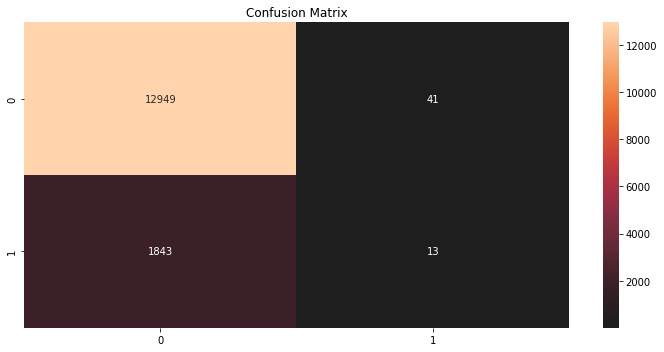

In [145]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM.png")


plt.show()

In [146]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  87.30971305402129 %


In [147]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12990
           1       0.24      0.01      0.01      1856

    accuracy                           0.87     14846
   macro avg       0.56      0.50      0.47     14846
weighted avg       0.80      0.87      0.82     14846



In [148]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.875406,0.996844,0.932186,12990.000000
1,0.240741,0.007004,0.013613,1856.000000
accuracy,0.873097,0.873097,0.873097,0.873097
macro avg,0.558073,0.501924,0.472899,14846.000000
weighted avg,0.796062,0.873097,0.817349,14846.000000


In [149]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  1884
Wrong percentage :  12.69 %


In [150]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.         0.00315627 1.        ]
True Postitve Rate Value Value  :  [0.         0.00700431 1.        ]
thresholds Value  :  [2 1 0]
